<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center>  Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. 

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите тетрадку в соответствующем Peer Review. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/1EbjK7-hF-Gepi6RH-K5I2XeiYGRoY0LNDx03QmLu9Xo). 

## Часть 1. Построение признаков

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = 'capstone_user_identification'

In [17]:
pd.to_datetime(pd.read_csv(PATH_TO_DATA + '/3users/user0001.csv')['timestamp'])[0]

Timestamp('2013-11-15 09:28:17')

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [29]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    lst = np.array(sorted(glob(path_to_csv_files + '/*')))
    free_site_id = 1
    ans = []
    d = pickle.load(open(site_freq_path, 'br'))
    for i, file in enumerate(lst):
        user_id = int(file[-8:-4])
        df = pd.read_csv(file)
        sites = df['site']
        timestamps = pd.to_datetime(df['timestamp'])
        del df
        start = 0
        #print(user_id, sites, timestamps)
        while start < len(sites):
            ans.append([0] * (2 * session_length + 4))
            ans[-1][-1] = user_id
            for j, site in enumerate(sites[start:start + session_length]):
                ans[-1][j] = d[site][0]
            for j, (first, second) in enumerate(zip(timestamps[start:start + session_length - 1], 
                                                    timestamps[start + 1:start + session_length])):
                ans[-1][j + session_length] = pd.Timedelta(second - first).seconds
            ans[-1][-5] = pd.Timedelta(timestamps[min(start + session_length - 1, len(timestamps) - 1)] - timestamps[start]).seconds
            ans[-1][-4] = len(np.unique(sites[start:start+session_length]))
            ans[-1][-3] = timestamps[start].hour
            ans[-1][-2] = timestamps[start].dayofweek
            start += window_size
    return pd.DataFrame(ans, columns=feature_names)

**Проверим функцию на игрушечном примере.**

In [30]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

In [31]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1,2,2,3,2,4,5,6,7,8,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,1,4,4,4,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
2,1,2,9,9,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
3,10,4,2,4,2,4,4,6,11,10,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
4,10,4,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


In [5]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,3,2,2,7,2,1,8,5,9,10,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,3,1,1,1,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
2,3,2,6,6,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
3,4,1,2,1,2,1,1,5,11,4,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
4,4,1,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [79]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)

CPU times: user 8.94 s, sys: 24.8 ms, total: 8.96 s
Wall time: 8.82 s


In [80]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1,2,3,4,3,3,4,3,5,3,10,0,0,1,20,1,0,1,0,33,5,8,4,31
1,6,7,8,9,3,10,11,12,13,14,1,0,163,105,0,1,3,3,8,284,10,8,4,31
2,14,4,14,14,15,16,6,17,18,14,0,14,1,242,0,0,1,0,0,258,7,8,4,31
3,19,20,19,14,14,14,14,21,22,23,2,1,0,1,25,1,0,0,0,30,6,8,4,31
4,24,14,15,25,26,27,28,29,30,29,1,0,1,1,1,0,1,1,0,6,9,8,4,31


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [81]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)

CPU times: user 1min 43s, sys: 436 ms, total: 1min 43s
Wall time: 1min 42s


In [82]:
train_data_150users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1,1,2,3,1,2,1,3,4,5,1,1,1,4,0,1,0,49,0,57,5,8,4,6
1,3,6,7,4,5,5,8,9,10,10,0,0,26,1,10,73,0,1504,4,1618,8,8,4,6
2,5,11,1,1,1,1,9,5,3,1,1,10,1,5,16,56,1917,0,4,2010,5,8,4,6
3,1,1,12,12,13,12,12,1,14,1,1,0,1,0,118,420,1460,6,0,2006,4,9,4,6
4,1,1,15,1,16,17,16,17,18,15,4,3,0,1,0,1,0,1,0,10,5,9,4,6


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [36]:
new_features_10users = train_data_10users[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]
new_features_150users = train_data_150users[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]

In [37]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

**<font color='red'>Вопрос 1. </font> Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [38]:
train_data_10users['session_timespan'].median()

37.0

**<font color='red'>Вопрос 2. </font> Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [39]:
train_data_10users['day_of_week'].median()

2.0

**<font color='red'>Вопрос 3. </font>Выведите медианный час начала сессии для сессий 150 пользователей.**

In [40]:
train_data_150users['start_hour'].median()

13.0

**<font color='red'>Вопрос 4. </font>Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [41]:
train_data_150users['#unique_sites'].median()

7.0

## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [58]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [57]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

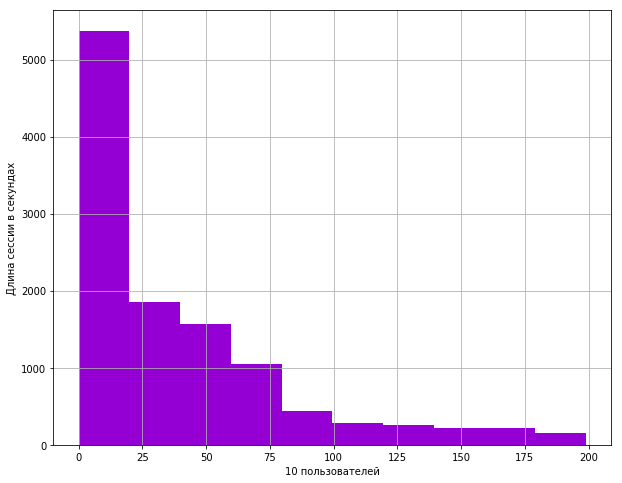

In [48]:
train_data_10users['session_timespan'][\
    train_data_10users['session_timespan']<200].hist(figsize=(10, 8), color='darkviolet')
plt.xlabel('10 пользователей')
plt.ylabel('Длина сессии в секундах')
plt.show()

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

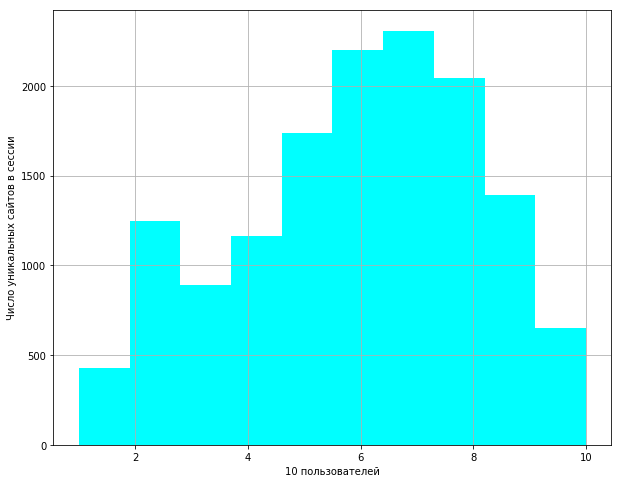

In [49]:
train_data_10users['#unique_sites'].hist(figsize=(10, 8), color='aqua')
plt.xlabel('10 пользователей')
plt.ylabel('Число уникальных сайтов в сессии')
plt.show()

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

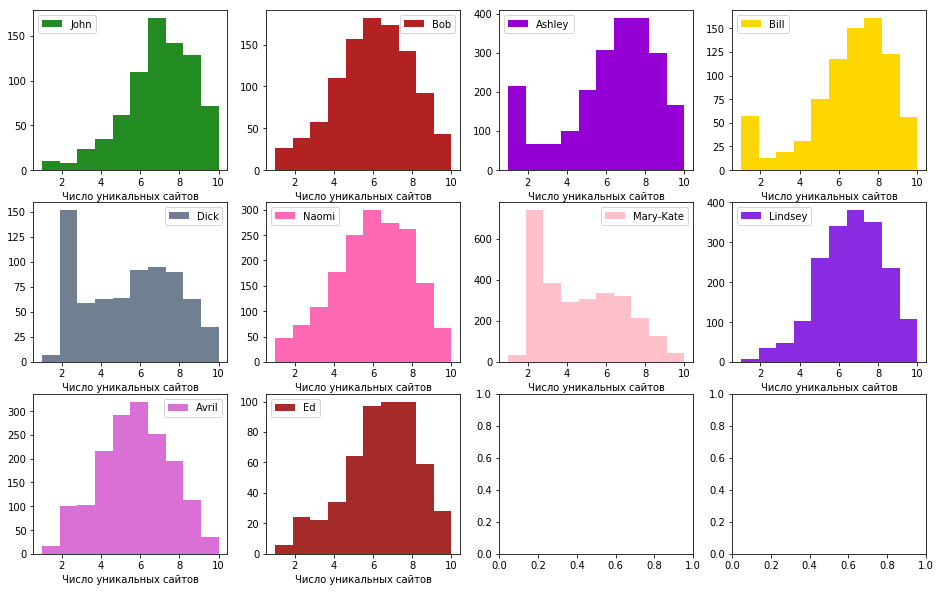

In [96]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in enumerate(train_data_10users.groupby('target')): 
    axes[idx // 4, idx % 4].hist(sub_df['#unique_sites'], label='{}'.format(id_name_dict[user]), color=color_dic[id_name_dict[user]])
    axes[idx // 4, idx % 4].set_xlabel('Число уникальных сайтов')
    axes[idx // 4, idx % 4].legend()

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

Text(0, 0.5, 'Час начала сессии')

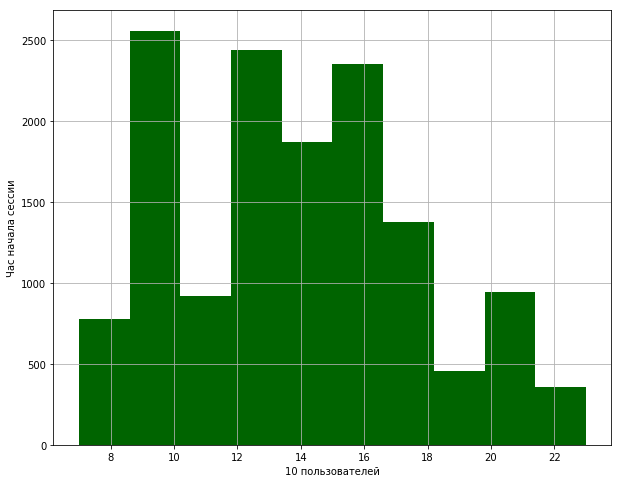

In [97]:
train_data_10users['start_hour'].hist(figsize=(10, 8), color='darkgreen')
plt.xlabel('10 пользователей')
plt.ylabel('Час начала сессии')

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

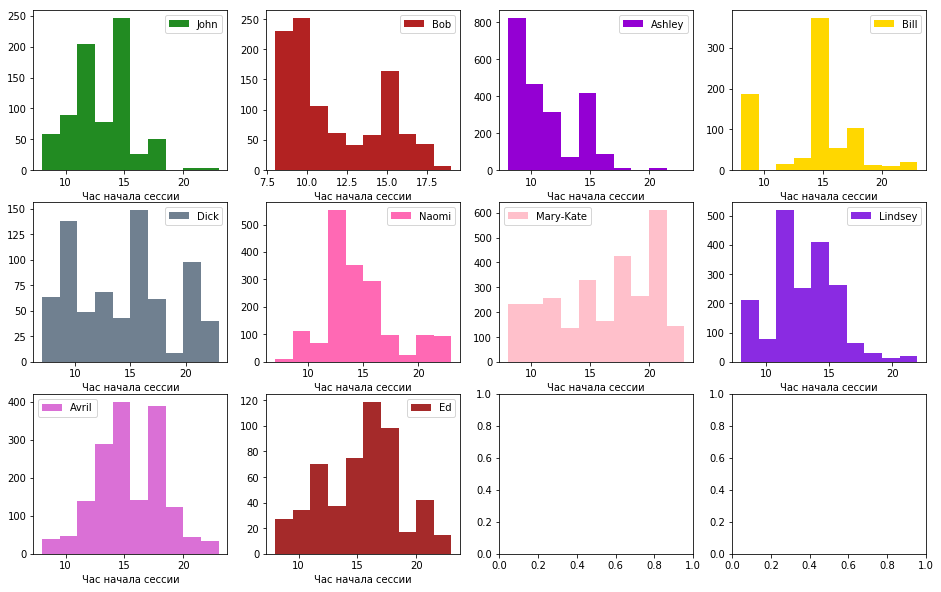

In [98]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in enumerate(train_data_10users.groupby('target')): 
    axes[idx // 4, idx % 4].hist(sub_df['start_hour'], label='{}'.format(id_name_dict[user]), color=color_dic[id_name_dict[user]])
    axes[idx // 4, idx % 4].set_xlabel('Час начала сессии')
    axes[idx // 4, idx % 4].legend()

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

Text(0, 0.5, 'День недели')

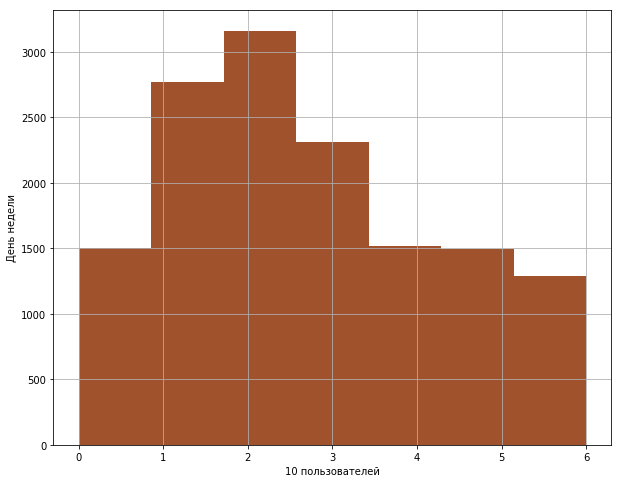

In [100]:
train_data_10users['day_of_week'].hist(figsize=(10, 8), color='sienna', bins=7)
plt.xlabel('10 пользователей')
plt.ylabel('День недели')

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

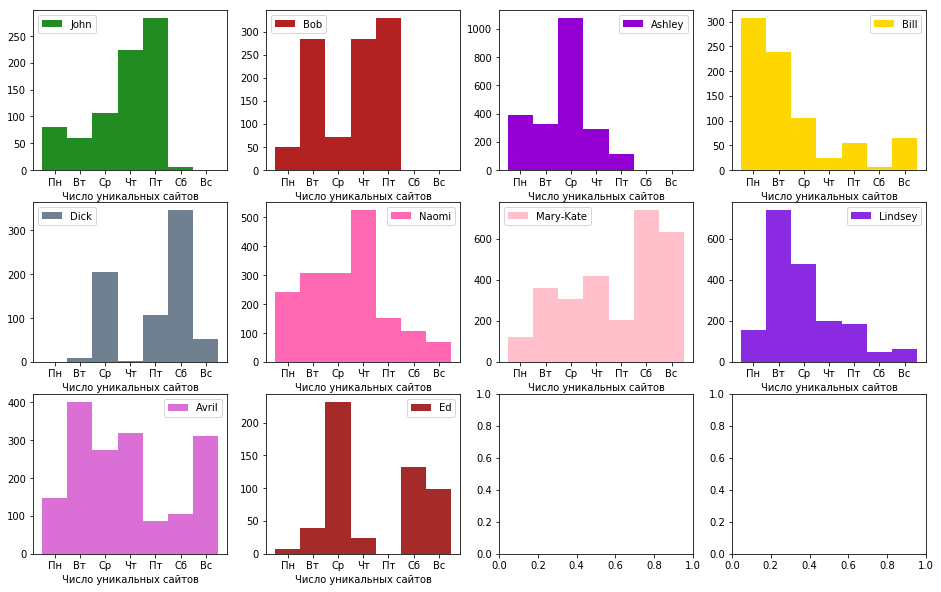

In [123]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in enumerate(train_data_10users.groupby('target')): 
    axes[idx // 4, idx % 4].hist(sub_df['day_of_week'], bins=[-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5], label='{}'.format(id_name_dict[user]), color=color_dic[id_name_dict[user]])
    axes[idx // 4, idx % 4].set_xlabel('Число уникальных сайтов')
    axes[idx // 4, idx % 4].set_xticks(range(7))
    axes[idx // 4, idx % 4].set_xticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
    axes[idx // 4, idx % 4].legend()

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

1) В целом, профиль распределения числа сайтов в сессии похожий у всех пользователей, однако есть несколько тех, кому свойственно посещать за сессию 1 или 2 сайта, в то время как другие так делают очень редко.

2) У всех сессии чаще начинаются в разное время: у кого-то утром, у кого-то днем, у кого-то вечером. При этом у некоторых почти все сессии начинаются в пределах нескольких часов, а у других распределение более равномерное.

3) Четко видно, что некоторые люди в какие-то дни вообще не выходят в интернет, кто-то выходит в интернет больше на выходных, кто-то наоборот.

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [125]:
with open(os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'), 'br') as inf:
    site_freq_10users = pickle.load(inf)
site_freq_10users

{'fpdownload2.macromedia.com': (1, 88),
 'laposte.net': (2, 23),
 'www.laposte.net': (3, 119),
 'www.google.com': (4, 5441),
 'match.rtbidder.net': (5, 84),
 'x2.vindicosuite.com': (6, 37),
 'rp.gwallet.com': (7, 88),
 'pool-eu-ie.creative-serving.com': (8, 18),
 'dl.javafx.com': (9, 65),
 'ajax.googleapis.com': (10, 711),
 'api.dailymotion.com': (11, 40),
 'i1-js-14-3-01-11074-266576264-i.init.cedexis-radar.net': (12, 1),
 'limelight.cedexis.com': (13, 78),
 'webmail.laposte.net': (14, 399),
 'www.facebook.com': (15, 4141),
 'rubicon-match.dotomi.com': (16, 55),
 'pr.ybp.yahoo.com': (17, 47),
 'dtm.ccs.com': (18, 12),
 'b12.myspace.com': (19, 31),
 'i1-js-14-3-01-11074-845302217-i.init.cedexis-radar.net': (20, 1),
 'trk.adbutter.net': (21, 11),
 'rs.mediapostcommunication.net': (22, 85),
 'av.mediapostcommunication.net': (23, 133),
 'rbp.mxptint.net': (24, 46),
 'i1-js-14-3-01-11074-25651477-i.init.cedexis-radar.net': (25, 1),
 'level3.cedexis.com': (26, 64),
 'probe.cedexis.org': (27

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [127]:
site_freq_10users_top10 = sorted(site_freq_10users.items(), key=lambda x: -x[1][1])[:10]
print(site_freq_10users_top10)

[('s.youtube.com', (210, 8300)), ('www.google.fr', (51, 7813)), ('www.google.com', (4, 5441)), ('mail.google.com', (183, 4158)), ('www.facebook.com', (15, 4141)), ('apis.google.com', (52, 3758)), ('r3---sn-gxo5uxg-jqbe.googlevideo.com', (700, 3244)), ('r1---sn-gxo5uxg-jqbe.googlevideo.com', (214, 3094)), ('plus.google.com', (187, 2630)), ('accounts.google.com', (184, 2089))]


In [133]:
top10_freqs = np.array([x[1][1] for x in site_freq_10users_top10])
top10_sites = np.array([x[0] for x in site_freq_10users_top10])

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

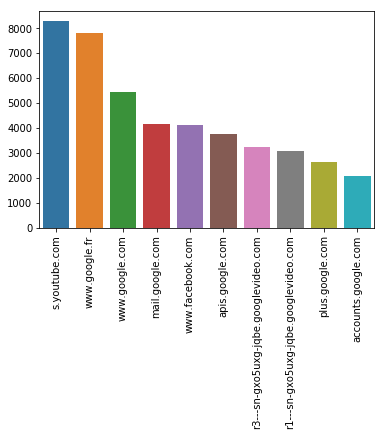

In [137]:
sns.barplot(top10_sites, top10_freqs)
plt.xticks(rotation=90)
plt.show()

## Часть 3. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

День/ночь, месяц, число топ-30 сайтов в сессии

In [144]:
def feature_engineering(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    lst = np.array(sorted(glob(path_to_csv_files + '/*')))
    ans = []
    d = pickle.load(open(site_freq_path, 'br'))
    top30 = [x[0] for x in sorted(d.items(), key=lambda x:-x[1][1])[:30]]
    for i, file in enumerate(lst):
        user_id = int(file[-8:-4])
        df = pd.read_csv(file)
        sites = df['site']
        timestamps = pd.to_datetime(df['timestamp'])
        del df
        start = 0
        #print(user_id, sites, timestamps)
        while start < len(sites):
            ans.append([0] * 4)
            ans[-1][-1] = user_id
            ans[-1][0] = 1 if (timestamps[start].hour >= 20 or timestamps[start].hour <= 5) else 0 # ночь или день
            ans[-1][1] = timestamps[start].month
            ans[-1][2] = sum([1 for x in sites[start:start+session_length] if x in top30])
            start += window_size
    return pd.DataFrame(ans, columns=feature_names)

In [145]:
new_features_10users = feature_engineering(os.path.join(PATH_TO_DATA, '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'),
                  feature_names=['night', 'month', '#top30sites', 'target'], session_length=10)

In [147]:
new_features_150users = feature_engineering(os.path.join(PATH_TO_DATA, '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'),
                  feature_names=['night', 'month', '#top30sites', 'target'], session_length=10)

**10. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

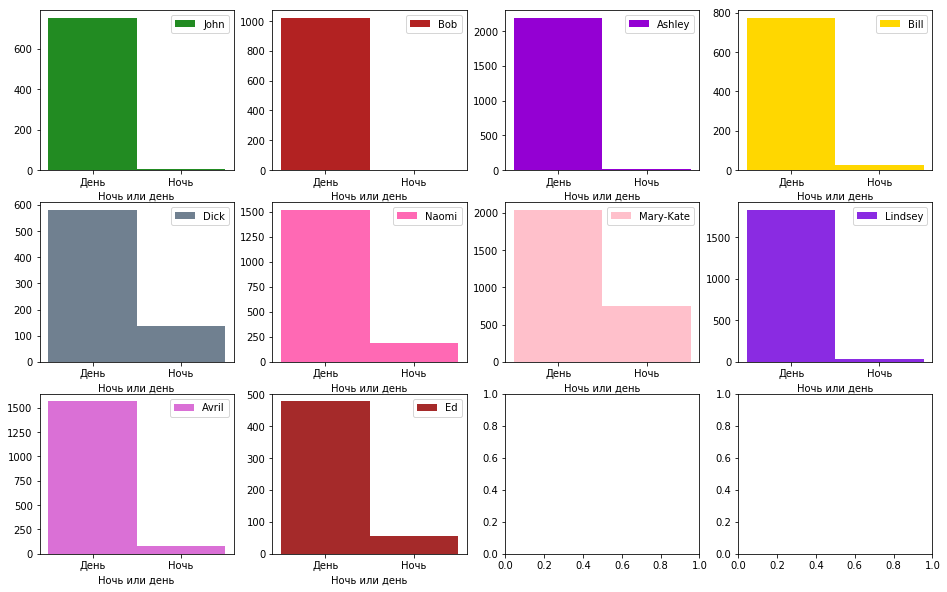

In [151]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in enumerate(new_features_10users.groupby('target')): 
    axes[idx // 4, idx % 4].hist(sub_df['night'], bins=[-0.5, 0.5, 1.5], label='{}'.format(id_name_dict[user]), color=color_dic[id_name_dict[user]])
    axes[idx // 4, idx % 4].set_xlabel('Ночь или день')
    axes[idx // 4, idx % 4].set_xticks([0, 1])
    axes[idx // 4, idx % 4].set_xticklabels(['День', 'Ночь'])
    axes[idx // 4, idx % 4].legend()

Большинство сессий происходит днем, при этом некоторые пользователи иногда выходят в интернет по ночам, а некоторые никогда.

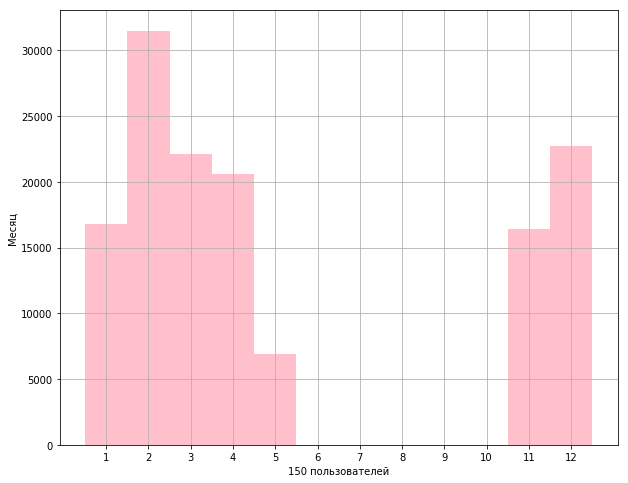

In [159]:
new_features_150users['month'].hist(figsize=(10, 8), color='pink', bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5])
plt.xlabel('150 пользователей')
plt.ylabel('Месяц')
plt.xticks(range(1, 13))
plt.show()

По какой-то причине, в интервале с июня по октябрь нет ни одной сессии. Большинство сессий приходится на февраль.

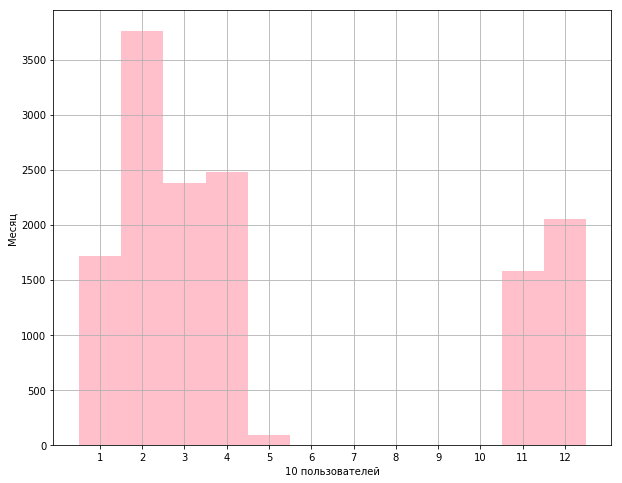

In [161]:
new_features_10users['month'].hist(figsize=(10, 8), color='pink', bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5])
plt.xlabel('10 пользователей')
plt.ylabel('Месяц')
plt.xticks(range(1, 13))
plt.show()

Здесь наблюдается та же самая ситуация.

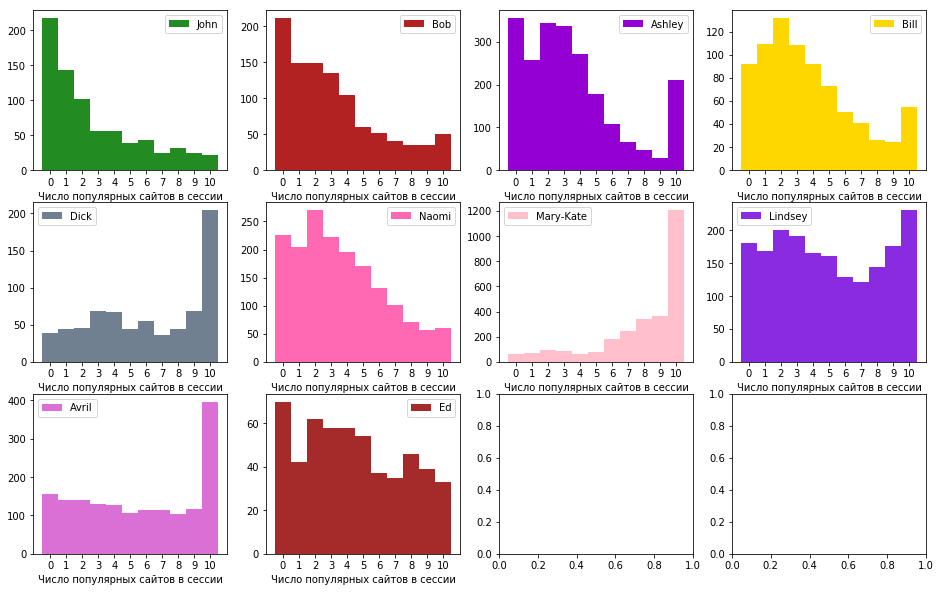

In [162]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in enumerate(new_features_10users.groupby('target')): 
    axes[idx // 4, idx % 4].hist(sub_df['#top30sites'], bins=[-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5], label='{}'.format(id_name_dict[user]), color=color_dic[id_name_dict[user]])
    axes[idx // 4, idx % 4].set_xlabel('Число популярных сайтов в сессии')
    axes[idx // 4, idx % 4].set_xticks(range(11))
    axes[idx // 4, idx % 4].legend()

Распределения у разных людей отличаются принципиально: кто-то чаще посещает редкие сайты, кто-то наоборот, в основном сидит на популярных.

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [163]:
selected_features_10users = pd.concat([train_data_10users[\
    ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']], 
                                       new_features_10users], axis=1) 
selected_features_150users =  pd.concat([train_data_150users[\
    ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']], 
                                       new_features_150users], axis=1) 

In [166]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

### Критерии оценки работы (только для Peer Review в специализации):
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 